<font size="6">PROJET 5 : Catégorisez automatiquement des questions </font>

**Librairies**

In [1]:
# Data analyse
import pandas as pd
import numpy as np
import re
from pprint import pprint

In [50]:
# Visualisation
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models

In [124]:
# Preprocess and evaluation
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer

In [102]:
# Modèles
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

In [5]:
# spacy for lemmatization
import spacy
nlp = spacy.load("en_core_web_md")

# Chargement des données

## Chargement

In [6]:
df = pd.read_csv("QueryResults.csv")

In [7]:
df

,Body,Title,Tags
0,<p>Is there any way to tinker with the iPhone ...,How can I develop for iPhone using a Windows d...,<ios><iphone><windows>
1,<p>I have this gigantic ugly string:</p>\n<pre...,My regex is matching too much. How do I make i...,<regex>
2,<p>I am Working with autolayout and constraint...,"What is ""Constrain to margin"" in Storyboard in...",<ios><xcode><storyboard><autolayout><xcode6>
3,<p>I'm learning objective-c and keep bumping i...,What does the @ symbol represent in objective-c?,<objective-c>
4,"<p>Is there a simple way, in a pretty standard...",Delete all but the most recent X files in bash,<bash><unix><scripting>
...,...,...,...
44990,"<p>Recently, I upgraded the version of Django ...",ImportError: cannot import name 'six' from 'dj...,<django>
44991,<p>How can I reject a promise that returned by...,How to reject in async/await syntax?,<javascript><asynchronous><typescript><es6-pro...
44992,<p>I have 2 entities that are related as one t...,.Net Core 3.0 possible object cycle was detect...,<c#><asp.net-core><entity-framework-core>
44993,<h2>Problem</h2>\n\n<p>I want to return a file...,Return file in ASP.Net Core Web API,<c#><asp.net-core><.net-core><asp.net-core-web...


## Nettoyage

In [8]:
def remove_punctuation_and_number(text):
    """remove all punctuation and number"""
    return text.translate(str.maketrans(" ", " ", charac)) 


def remove_non_alphabetical_character(text):
    """remove all non-alphabetical character"""
    text = re.sub("[^a-z]+", " ", text.lower()) # remove all non-alphabetical character
    text = re.sub("\s+", " ", text.lower()) # remove whitespaces left after the last operation
    return text

<>:9: DeprecationWarning: invalid escape sequence \s
<>:9: DeprecationWarning: invalid escape sequence \s
C:\Users\ELISEA~1\AppData\Local\Temp/ipykernel_14068/3580948513.py:9: DeprecationWarning: invalid escape sequence \s
  text = re.sub("\s+", " ", text.lower()) # remove whitespaces left after the last operation


In [9]:
# Nettoyage de la colonne Body
df['Body'] = [re.sub('<[^>]+>', '', i) for i in df['Body']]
df['Body'] = [re.sub('\n', '', i) for i in df['Body']]

df['Title'] = df['Title'].apply(lambda x: remove_non_alphabetical_character(x)) 
df['Body'] = df['Body'].apply(lambda x: remove_non_alphabetical_character(x)) 

# Nettoyage de la colonne Tags
tags_nettoye = [re.sub('><', ',', i)[1:-1] for i in df['Tags']]

In [10]:
df['Tags'] = tags_nettoye

In [11]:
df

,Body,Title,Tags
0,is there any way to tinker with the iphone sdk...,how can i develop for iphone using a windows d...,"ios,iphone,windows"
1,i have this gigantic ugly string j transaction...,my regex is matching too much how do i make it...,regex
2,i am working with autolayout and constraints a...,what is constrain to margin in storyboard in x...,"ios,xcode,storyboard,autolayout,xcode6"
3,i m learning objective c and keep bumping into...,what does the symbol represent in objective c,objective-c
4,is there a simple way in a pretty standard uni...,delete all but the most recent x files in bash,"bash,unix,scripting"
...,...,...,...
44990,recently i upgraded the version of django fram...,importerror cannot import name six from django...,django
44991,how can i reject a promise that returned by an...,how to reject in async await syntax,"javascript,asynchronous,typescript,es6-promise..."
44992,i have entities that are related as one to man...,net core possible object cycle was detected w...,"c#,asp.net-core,entity-framework-core"
44993,problemi want to return a file in my asp net w...,return file in asp net core web api,"c#,asp.net-core,.net-core,asp.net-core-webapi"


In [12]:
df.shape

(44995, 3)

In [13]:
# Vérification des Nan
df.dropna().shape

(44995, 3)

In [14]:
# Vérification des doublons
df.drop_duplicates().shape

(44995, 3)

In [15]:
df

,Body,Title,Tags
0,is there any way to tinker with the iphone sdk...,how can i develop for iphone using a windows d...,"ios,iphone,windows"
1,i have this gigantic ugly string j transaction...,my regex is matching too much how do i make it...,regex
2,i am working with autolayout and constraints a...,what is constrain to margin in storyboard in x...,"ios,xcode,storyboard,autolayout,xcode6"
3,i m learning objective c and keep bumping into...,what does the symbol represent in objective c,objective-c
4,is there a simple way in a pretty standard uni...,delete all but the most recent x files in bash,"bash,unix,scripting"
...,...,...,...
44990,recently i upgraded the version of django fram...,importerror cannot import name six from django...,django
44991,how can i reject a promise that returned by an...,how to reject in async await syntax,"javascript,asynchronous,typescript,es6-promise..."
44992,i have entities that are related as one to man...,net core possible object cycle was detected w...,"c#,asp.net-core,entity-framework-core"
44993,problemi want to return a file in my asp net w...,return file in asp net core web api,"c#,asp.net-core,.net-core,asp.net-core-webapi"


**Fusion de la colonne titre et de la colonne contenu**

In [16]:
df['Title+Body'] = df['Body'] + df['Title']
df = df[['Title+Body',"Tags"]]

In [132]:
df.head()

,Title+Body,Tags,supervised-learning,many-to-one,vue.js,penetration-testing,facet-wrap,wstring,cost-based-optimizer,datecell,...,observer-pattern,article,sizewithfont,member,sublime-text-plugin,sql-server,precompiled-headers,multi-table-delete,inversion,querying
0,is there any way to tinker with the iphone sdk...,"[ios, iphone, windows]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,i have this gigantic ugly string j transaction...,[regex],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,i am working with autolayout and constraints a...,"[ios, xcode, storyboard, autolayout, xcode6]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,i m learning objective c and keep bumping into...,[objective-c],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,is there a simple way in a pretty standard uni...,"[bash, unix, scripting]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocess : tokenisation et analyse des fréquences

## Tokenisation

In [17]:
data = df['Title+Body'].values.tolist()

In [18]:
data

['is there any way to tinker with the iphone sdk on a windows machine are there plans for an iphone sdk version for windows the only other way i can think of doing this is to run a mac vm image on a vmware server running on windows although i m not too sure how legal this is how can i develop for iphone using a windows development machine ',
 'i have this gigantic ugly string j transaction a started on amj project name e foo pfj job name mbiek direct mail testj document completed successfullyi m trying to extract pieces from it using regex in this case i want to grab everything after project name up to the part where it says j the is going to be a different number every time here s the regex i ve been playing with project name s s j the problem is that it doesn t stop until it hits the j at the end how do i make the regex stop at the first occurrence of j my regex is matching too much how do i make it stop ',
 'i am working with autolayout and constraints and found there is a constrain

**Tokenize words and clean-up text**

In [19]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['is', 'there', 'any', 'way', 'to', 'tinker', 'with', 'the', 'iphone', 'sdk', 'on', 'windows', 'machine', 'are', 'there', 'plans', 'for', 'an', 'iphone', 'sdk', 'version', 'for', 'windows', 'the', 'only', 'other', 'way', 'can', 'think', 'of', 'doing', 'this', 'is', 'to', 'run', 'mac', 'vm', 'image', 'on', 'vmware', 'server', 'running', 'on', 'windows', 'although', 'not', 'too', 'sure', 'how', 'legal', 'this', 'is', 'how', 'can', 'develop', 'for', 'iphone', 'using', 'windows', 'development', 'machine']]


**Creating Bigram and Trigram Models**

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=50) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=50)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['is', 'there', 'any', 'way', 'to', 'tinker', 'with', 'the', 'iphone', 'sdk', 'on', 'windows', 'machine', 'are', 'there', 'plans', 'for', 'an', 'iphone', 'sdk', 'version', 'for', 'windows', 'the', 'only', 'other', 'way', 'can', 'think', 'of', 'doing', 'this', 'is', 'to', 'run', 'mac', 'vm', 'image', 'on', 'vmware', 'server', 'running', 'on', 'windows', 'although', 'not', 'too', 'sure', 'how', 'legal', 'this', 'is', 'how', 'can', 'develop', 'for', 'iphone', 'using', 'windows', 'development', 'machine']


**Stopwords model**

In [21]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend([liste de mots à retirer si besoin])

**Remove stopwords, make bigrams and lemmatize**

In [22]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [23]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['way', 'machine', 'plan', 'version', 'way', 'think', 'run', 'image', 'vmware', 'server', 'run', 'window', 'sure', 'legal', 'develop', 'iphone', 'use', 'window', 'development', 'machine']]


In [24]:
data_lemmatized

[['way',
  'machine',
  'plan',
  'version',
  'way',
  'think',
  'run',
  'image',
  'vmware',
  'server',
  'run',
  'window',
  'sure',
  'legal',
  'develop',
  'iphone',
  'use',
  'window',
  'development',
  'machine'],
 ['gigantic',
  'ugly',
  'string',
  'transaction',
  'start',
  'project',
  'name',
  'pfj',
  'job',
  'name',
  'mbiek',
  'direct',
  'mail',
  'testj',
  'document',
  'complete',
  'try',
  'extract',
  'piece',
  'use',
  'regex',
  'case',
  'grab',
  'project',
  'name',
  'part',
  'say',
  'go',
  'different',
  'number',
  'time',
  'regex',
  'play',
  'project',
  'name',
  'problem',
  'stop',
  'hit',
  'end',
  'make',
  'regex',
  'stop',
  'first_occurrence',
  'regex',
  'match',
  'much',
  'make',
  'stop'],
 ['work',
  'autolayout',
  'constraint',
  'find',
  'constrain',
  'margin',
  'option',
  'check',
  'default',
  'create',
  'test',
  'project',
  'add',
  'viewcontroller',
  'frame',
  'set',
  'size',
  'view',
  'add',
  'see

## Tokenization des tags

In [25]:
df['Tags'] = [i.lower() for i in df['Tags']]
df['Tags'] = [i.split(",") for i in df['Tags']]

C:\Users\ELISEA~1\AppData\Local\Temp/ipykernel_14068/594312384.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tags'] = [i.lower() for i in df['Tags']]
C:\Users\ELISEA~1\AppData\Local\Temp/ipykernel_14068/594312384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tags'] = [i.split(",") for i in df['Tags']]


## Une colonne par tags

In [26]:
tags = []

for i in df['Tags']:
    tags = tags + i
    
tags = set(tags)

In [27]:
len(tags)

9474

In [28]:
for i in tags:
    df[i] = [1 if i in y else 0 for y in df['Tags']]

C:\Users\ELISEA~1\AppData\Local\Temp/ipykernel_14068/1826741131.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i] = [1 if i in y else 0 for y in df['Tags']]


In [29]:
df.head()

,Title+Body,Tags,supervised-learning,many-to-one,vue.js,penetration-testing,facet-wrap,wstring,cost-based-optimizer,datecell,...,observer-pattern,article,sizewithfont,member,sublime-text-plugin,sql-server,precompiled-headers,multi-table-delete,inversion,querying
0,is there any way to tinker with the iphone sdk...,"[ios, iphone, windows]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,i have this gigantic ugly string j transaction...,[regex],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,i am working with autolayout and constraints a...,"[ios, xcode, storyboard, autolayout, xcode6]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,i m learning objective c and keep bumping into...,[objective-c],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,is there a simple way in a pretty standard uni...,"[bash, unix, scripting]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Distribution des tags

histogramme du nbre d'individu par tags pour savoir si le tags est utile ou non (s'il n'a qu'un individu, sert à rien)

In [30]:
# Nbre d'occurence des tags
sum_column = df.iloc[:,2:].sum(axis=0)

In [31]:
print (sum_column.sort_values())

supervised-learning       1
mongrel2                  1
npm-live-server           1
mandrill                  1
swiperefreshlayout        1
                       ... 
android                2863
c#                     3281
java                   4000
python                 4683
javascript             4777
Length: 9474, dtype: int64


<AxesSubplot:>

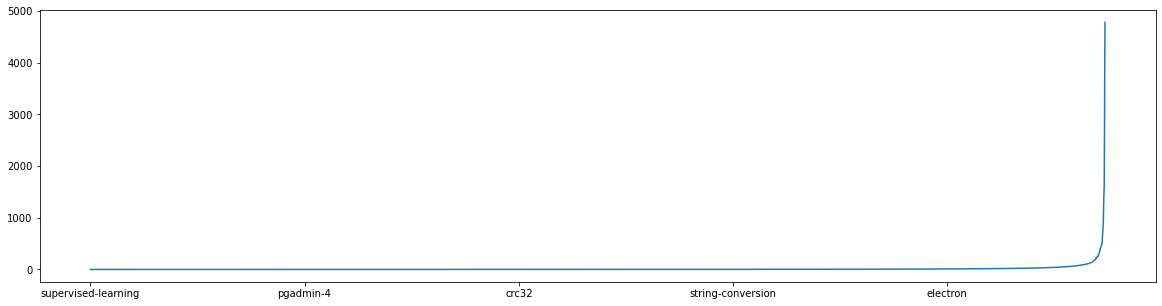

In [32]:
plt.figure(figsize=(20, 5))
sum_column.sort_values().plot()

On ne va garder que les 100 tags les plus utilisés

Text(0.5, 1.0, "Nombre d'occurence du tag")

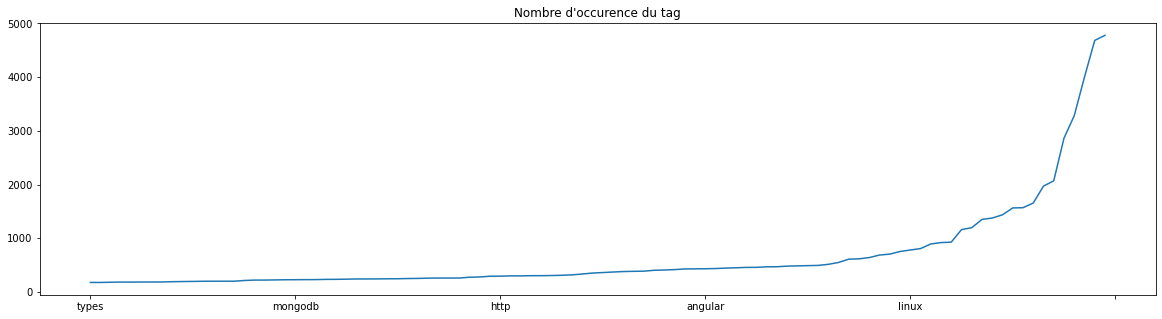

In [33]:
plt.figure(figsize=(20, 5))
sum_column.sort_values()[-100:].plot()
plt.title("Nombre d'occurence du tag")

In [34]:
df2 = df.drop(columns = sum_column.sort_values()[0:-100].index)

In [35]:
df2['nbre_tags'] = df2.iloc[:,2:].sum(axis=1)
df2.sort_values(by='nbre_tags')

,Title+Body,Tags,debugging,ajax,regex,r,google-chrome,command-line,postgresql,oop,...,datetime,docker,c,visual-studio,rest,asp.net-mvc,ruby,class,sql-server,nbre_tags
20165,i have a selenium test suite that runs many te...,"[selenium, selenium-webdriver, webdriver, sele...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41400,there is slack private channel with slackbot r...,"[bots, slack]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18515,is there a shortcut to run all cells in an ipy...,"[keyboard-shortcuts, jupyter-notebook]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7191,i usually have a policy in my project to never...,[cmake],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36415,how do we achieve a recursive directory listin...,"[dos, directory-listing]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25519,i would like to execute a single php statement...,"[php, linux, function, shell, command-line]",0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,5
40037,ajax url test html error function do somethin...,"[javascript, jquery, html, css, ajax]",0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
40036,the lt video gt tags autoplay autoplay attribu...,"[jquery, ios, objective-c, html, cocoa-touch]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
17480,i have a dataframe in pandas and i m trying to...,"[python, pandas, numpy, dataframe, types]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5


In [36]:
# On retire tous les individus qui n'ont pas de tags parmi les 100 premiers 
df2 = df2.loc[df2['nbre_tags']>0]
df2.drop(columns = ['nbre_tags','Tags'], inplace=True)

In [37]:
# Nbre d'occurence des 100 premiers tags
sum_column2 = df2.iloc[:,2:-1].sum(axis=0)
print (sum_column2.sort_values())

java-8          178
types           178
forms           182
collections     185
class           185
               ... 
android        2863
c#             3281
java           4000
python         4683
javascript     4777
Length: 98, dtype: int64


In [38]:
# Regarde la différence de dataset, la perte des individus
print('df2 dimension:',df2.shape)
print('df dimension:',df.shape)

df2 dimension: (40730, 101)
df dimension: (44995, 9476)


In [39]:
df2

,Title+Body,debugging,ajax,regex,r,google-chrome,command-line,postgresql,oop,collections,...,cocoa-touch,datetime,docker,c,visual-studio,rest,asp.net-mvc,ruby,class,sql-server
0,is there any way to tinker with the iphone sdk...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,i have this gigantic ugly string j transaction...,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,i am working with autolayout and constraints a...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,i m learning objective c and keep bumping into...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,is there a simple way in a pretty standard uni...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44990,recently i upgraded the version of django fram...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44991,how can i reject a promise that returned by an...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44992,i have entities that are related as one to man...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
44993,problemi want to return a file in my asp net w...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Topic Modeling Model

## Latent Dirichlet Allocation

**Create the dictionary and Corpus needed for topic modeling**

In [41]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[0])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 2)]


In [42]:
#Exemple de mot du dictionnaire
id2word[0]

'develop'

In [43]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('develop', 1),
  ('development', 1),
  ('image', 1),
  ('iphone', 1),
  ('legal', 1),
  ('machine', 2),
  ('plan', 1),
  ('run', 2),
  ('server', 1),
  ('sure', 1),
  ('think', 1),
  ('use', 1),
  ('version', 1),
  ('vmware', 1),
  ('way', 2),
  ('window', 2)]]


**Building the topic model**

In [72]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

**View the topics in LDA model**

In [73]:
# Print the Keyword in the 6 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.048*"datum" + 0.026*"column" + 0.025*"table" + 0.020*"swift" + '
  '0.019*"name" + 0.018*"field" + 0.018*"variable" + 0.018*"select" + '
  '0.017*"date" + 0.017*"row"'),
 (1,
  '0.051*"file" + 0.040*"error" + 0.025*"run" + 0.018*"project" + 0.017*"app" '
  '+ 0.014*"try" + 0.014*"version" + 0.014*"get" + 0.013*"module" + '
  '0.012*"command"'),
 (2,
  '0.049*"use" + 0.011*"code" + 0.009*"see" + 0.009*"make" + 0.009*"question" '
  '+ 0.008*"work" + 0.008*"build" + 0.008*"request" + 0.007*"know" + '
  '0.007*"problem"'),
 (3,
  '0.025*"function" + 0.022*"string" + 0.021*"value" + 0.017*"type" + '
  '0.016*"name" + 0.015*"return" + 0.014*"get" + 0.014*"list" + 0.014*"way" + '
  '0.014*"object"'),
 (4,
  '0.080*"quot" + 0.066*"class" + 0.032*"com" + 0.030*"java" + 0.026*"public" '
  '+ 0.023*"method" + 0.022*"int" + 0.019*"json" + 0.019*"new" + '
  '0.016*"return"'),
 (5,
  '0.060*"d" + 0.054*"android" + 0.037*"view" + 0.029*"i" + 0.029*"item" + '
  '0.028*"image" + 0.024*"key" +

**Compute Model Perplexity and Coherence Score**

In [74]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.946100857689559

Coherence Score:  0.4784714452221664


**Visualize the topics-keywords**

In [101]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.194437 -0.106748       1        1  31.334945
3     -0.136683  0.010504       2        1  25.183876
1     -0.133502 -0.026249       3        1  18.837302
4      0.068891  0.391999       4        1   9.285651
0      0.017560 -0.144448       5        1   8.388940
5      0.378171 -0.125057       6        1   6.969287, topic_info=           Term          Freq         Total Category  logprob  loglift
2229       quot  16411.000000  16411.000000  Default  30.0000  30.0000
68         file  21060.000000  21060.000000  Default  29.0000  29.0000
212       class  13557.000000  13557.000000  Default  28.0000  28.0000
11          use  41302.000000  41302.000000  Default  27.0000  27.0000
343           d   9279.000000   9279.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
2086  container   1638.697714   2724.403131   Topic6  -4.5448   2.1553
462       leave   1005.758798   1678.380084   Topic6  -5.0330   2.1516
376       right   1122.503099   2807.821240   Topic6  -4.9231   1.7468
86         size   1049.919341   3114.161318   Topic6  -4.9900   1.5764
84          set   1017.740097   9077.148058   Topic6  -5.0211   0.4755

[315 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
177       1  0.946718    access
177       3  0.052971    access
1869      6  0.999643  activity
54        1  0.001221       add
54        2  0.636913       add
...     ...       ...       ...
989       6  0.999719     width
15        3  0.999871    window
97        1  0.437019      work
97        2  0.390687      work
97        3  0.172253      work

[383 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 2, 5, 1, 6])

**Find the optimal number of topics for LDA?**

In [82]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=dictionary,
                                                num_topics= num_topics, 
                                                random_state=100, 
                                                update_every=1,
                                                chunksize=200,
                                                passes=10,
                                                alpha='auto',
                                                per_word_topics=True)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [83]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=3, limit=18, step=3)

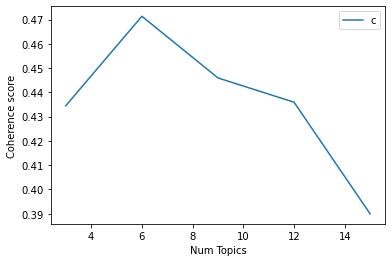

In [84]:
# Show graph
limit=18; start=3; step=3;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [85]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4345
Num Topics = 6  has Coherence Value of 0.4714
Num Topics = 9  has Coherence Value of 0.446
Num Topics = 12  has Coherence Value of 0.436
Num Topics = 15  has Coherence Value of 0.3899


In [86]:
# Select the model and print the topics
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.030*"java" + 0.026*"user" + 0.021*"server" + 0.020*"system" + '
  '0.020*"request" + 0.018*"com" + 0.015*"application" + 0.014*"service" + '
  '0.013*"web" + 0.013*"fail"'),
 (1,
  '0.058*"file" + 0.036*"error" + 0.022*"run" + 0.020*"project" + '
  '0.018*"version" + 0.016*"build" + 0.016*"app" + 0.014*"command" + '
  '0.013*"import" + 0.012*"find"'),
 (2,
  '0.046*"use" + 0.014*"work" + 0.012*"code" + 0.011*"way" + 0.010*"make" + '
  '0.009*"time" + 0.009*"want" + 0.009*"know" + 0.008*"change" + 0.008*"get"'),
 (3,
  '0.028*"string" + 0.025*"function" + 0.025*"class" + 0.024*"value" + '
  '0.023*"name" + 0.022*"return" + 0.020*"type" + 0.017*"object" + 0.014*"get" '
  '+ 0.014*"method"'),
 (4,
  '0.159*"quot" + 0.070*"list" + 0.058*"public" + 0.044*"git" + 0.041*"json" + '
  '0.024*"private" + 0.024*"branch" + 0.016*"group" + 0.015*"push" + '
  '0.013*"merge"'),
 (5,
  '0.051*"d" + 0.038*"android" + 0.025*"i" + 0.024*"table" + 0.024*"view" + '
  '0.024*"image" + 0.023*"colum

**Finding the dominant topic in each sentence**

In [87]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row[0], key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [88]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

In [89]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.4043,"file, error, run, project, version, build, app...",is there any way to tinker with the iphone sdk...
1,1,3.0,0.4133,"string, function, class, value, name, return, ...",i have this gigantic ugly string j transaction...
2,2,2.0,0.5146,"use, work, code, way, make, time, want, know, ...",i am working with autolayout and constraints a...
3,3,3.0,0.4753,"string, function, class, value, name, return, ...",i m learning objective c and keep bumping into...
4,4,2.0,0.4288,"use, work, code, way, make, time, want, know, ...",is there a simple way in a pretty standard uni...
5,5,2.0,0.5674,"use, work, code, way, make, time, want, know, ...",i am writing a java utility which helps me to ...
6,6,3.0,0.4583,"string, function, class, value, name, return, ...",i need to find out how to format numbers as st...
7,7,2.0,0.3465,"use, work, code, way, make, time, want, know, ...",without local access to the server is there an...
8,8,0.0,0.5303,"java, user, server, system, request, com, appl...",what are the best practices to consider when c...
9,9,3.0,0.5530,"string, function, class, value, name, return, ...",for a given class i would like to have tracing...


**Find the most representative document for each topic**

In [92]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.8135,"java, user, server, system, request, com, appl...",i have written a query to delete some objects ...
1,1.0,0.8448,"file, error, run, project, version, build, app...",i created a cmakelists txt that contains the f...
2,2.0,0.9133,"use, work, code, way, make, time, want, know, ...",in my experience getting dates times right whe...
3,3.0,0.8983,"string, function, class, value, name, return, ...",python has a built in function enumerate to ge...
4,4.0,0.8899,"quot, list, public, git, json, private, branch...",i have the following piece of base encoded dat...
5,5.0,0.8826,"d, android, i, table, view, image, column, tex...",i am having trouble with a scrolling listview ...


**Topic distribution across documents**

In [100]:
df_dominant_topics = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].groupby(['Dominant_Topic', 'Topic_Keywords'])['Topic_Keywords'].count().reset_index(name='Num_Documents')

df_dominant_topics['Perc_Documents'] = (df_dominant_topics['Num_Documents'])/(df_dominant_topics['Num_Documents'].sum())

df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"java, user, server, system, request, com, appl...",1497,0.033270
1,1.0,"file, error, run, project, version, build, app...",5604,0.124547
2,2.0,"use, work, code, way, make, time, want, know, ...",23799,0.528925
3,3.0,"string, function, class, value, name, return, ...",11220,0.249361
4,4.0,"quot, list, public, git, json, private, branch...",514,0.011423
5,5.0,"d, android, i, table, view, image, column, tex...",2361,0.052472


## Non-Negative Matrix Factorization

In [105]:
data

['is there any way to tinker with the iphone sdk on a windows machine are there plans for an iphone sdk version for windows the only other way i can think of doing this is to run a mac vm image on a vmware server running on windows although i m not too sure how legal this is how can i develop for iphone using a windows development machine ',
 'i have this gigantic ugly string j transaction a started on amj project name e foo pfj job name mbiek direct mail testj document completed successfullyi m trying to extract pieces from it using regex in this case i want to grab everything after project name up to the part where it says j the is going to be a different number every time here s the regex i ve been playing with project name s s j the problem is that it doesn t stop until it hits the j at the end how do i make the regex stop at the first occurrence of j my regex is matching too much how do i make it stop ',
 'i am working with autolayout and constraints and found there is a constrain

In [130]:
def process_text(text):
    text = casual_tokenizer(text)
    text = [SnowballStenner('english').stem(each) for each in text]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if ' ' not in each]
    return text


def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


def word_count(text):
    return len(str(text).split(' '))

In [128]:
data.apply(process_text)

AttributeError: 'list' object has no attribute 'apply'

In [112]:
# converting the given text term-document matrix
 
vectorizer = TfidfVectorizer(min_df=5, max_df=0.90, max_features=1500, stop_words='english')
X = vectorizer.fit_transform(data)
words = np.array(vectorizer.get_feature_names())

print(X)
print("X = ", words)

  (0, 351)	0.1574317630558659
  (0, 1414)	0.06939111668344933
  (0, 1296)	0.12604529292247732
  (0, 1143)	0.12279217768367005
  (0, 1189)	0.11287825638167746
  (0, 627)	0.1364816329972277
  (0, 1446)	0.2016065349246342
  (0, 779)	0.16351998096194953
  (0, 1142)	0.10681409083052182
  (0, 387)	0.11680247154550892
  (0, 1336)	0.1280349326385873
  (0, 1434)	0.11487947816587517
  (0, 780)	0.3068139160343776
  (0, 1468)	0.5271529012706196
  (0, 1167)	0.34548374626417927
  (0, 674)	0.5215142275621061
  (0, 1456)	0.15059444684160003
  (1, 800)	0.16455478019500971
  (1, 783)	0.17727451939688155
  (1, 424)	0.1140570782119332
  (1, 1266)	0.43599046505222266
  (1, 386)	0.09096167036253443
  (1, 1002)	0.09310848788291946
  (1, 1431)	0.08294469740496156
  (1, 1344)	0.09278459260118807
  :	:
  (44993, 1272)	0.06688743684870835
  (44994, 1136)	0.33341461457925753
  (44994, 925)	0.1466666209861027
  (44994, 1058)	0.4169264556635232
  (44994, 155)	0.3478569848705241
  (44994, 156)	0.15589924520183754
  

In [113]:
# Applying Non-Negative Matrix Factorization
 
nmf = NMF(n_components=10, solver="mu")
W = nmf.fit_transform(X)
H = nmf.components_

for i, topic in enumerate(H):
     print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[-10:]]])))

Topic 1: input,value,type,id,class,text,html,div,lt,gt
Topic 2: javascript,data,does,want,code,way,function,like,use,using
Topic 3: push,github,changes,files,remote,master,repository,commit,branch,git
Topic 4: height,width,activity,com,view,id,studio,app,layout,android
Topic 5: var,path,import,test,javascript,echo,input,file,json,quot
Topic 6: replace,split,int,strings,public,characters,str,character,convert,string
Topic 7: script,open,txt,command,path,directory,python,line,files,file
Topic 8: methods,object,void,static,int,method,public,difference,class,java
Topic 9: values,way,elements,item,value,element,numpy,python,list,array
Topic 10: data,server,id,query,database,select,mysql,column,sql,table
